In [46]:
import seaborn as sns
import requests
import zipfile
import io
import polars as pl
from matplotlib import pyplot as plt
from datetime import datetime, timedelta
from funding_crawler.viz import count_plot, perc_comp


def count_plot(df, col):
    lst = [x for xs in df[col] if xs is not None for x in xs]

    series = pl.Series(col, lst)
    counts_df = (
        pl.DataFrame([series])
        .unpivot()
        .group_by("value")
        .len()
        .sort("len", descending=True)
        .rename({"value": col, "len": "count"})
    )

    sns.barplot(data=counts_df, y=col, x="count", order=counts_df[col])
    plt.show()

In [47]:
data_url = "https://foerderdatenbankdump.fra1.cdn.digitaloceanspaces.com/data/parquet_data.zip"

In [48]:
response = requests.get(data_url)
response.raise_for_status()

with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    file_name = z.namelist()[0]
    with z.open(file_name) as f:
        df = pl.read_parquet(f)

print(f"{len(df)} Förderprogramme")
print(df.columns)
print(df.dtypes)

2454 Förderprogramme
['id_hash', 'id_url', 'url', 'title', 'description', 'more_info', 'legal_basis', 'contact_info_institution', 'contact_info_street', 'contact_info_city', 'contact_info_fax', 'contact_info_phone', 'contact_info_email', 'contact_info_website', 'funding_type', 'funding_area', 'funding_location', 'eligible_applicants', 'funding_body', 'further_links', 'checksum', 'license_info', 'previous_update_dates', 'last_updated', 'on_website_from', 'deleted']
[String, String, String, String, String, String, String, String, String, String, String, String, String, String, List(String), List(String), List(String), List(String), String, List(String), String, String, Null, Null, Datetime(time_unit='us', time_zone=None), Boolean]


In [49]:
current_date = datetime.today()

# Determine the most recent update date
if not df["last_updated"].is_null().all():
    most_recent_updated = df["last_updated"].max()
else:
    most_recent_updated = df["on_website_from"].max()

print("Today is:", current_date)
print("Most recent update (updates when crawler ran):", most_recent_updated)


Today is: 2025-06-19 18:01:31.747748
Most recent update (updates when crawler ran): 2025-06-19 14:40:33.793034


In [50]:
current_df = df.filter(pl.col("deleted") == False)
print(f"{len(current_df)} aktive Förderprogramme")

2454 aktive Förderprogramme


## Descriptive Statistics

### Funding Area

Multiple areas are possible per program

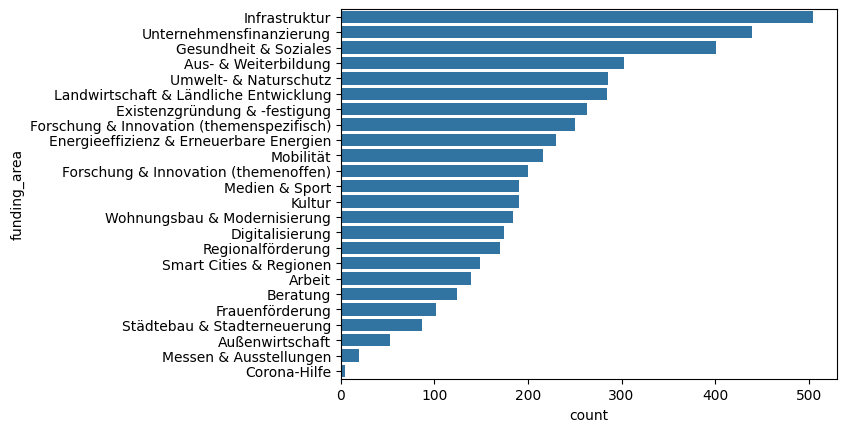

In [51]:
count_plot(df, "funding_area")

### Funding Location

Multiple applicant locations are possible per program.

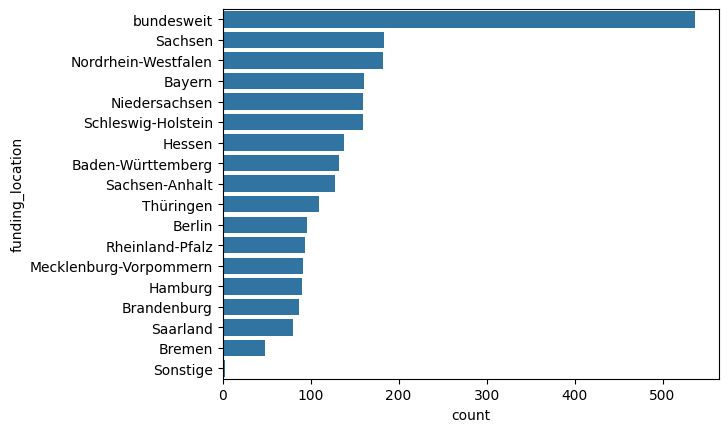

In [52]:
count_plot(df, "funding_location")

### Eligible Applicant Types

Multiple applicant types are possible per program

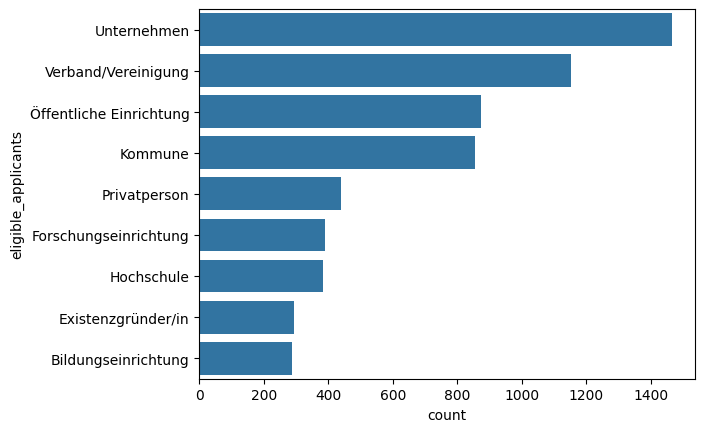

In [53]:
count_plot(df, "eligible_applicants")

### Funding Types
Multiple funding types are possible

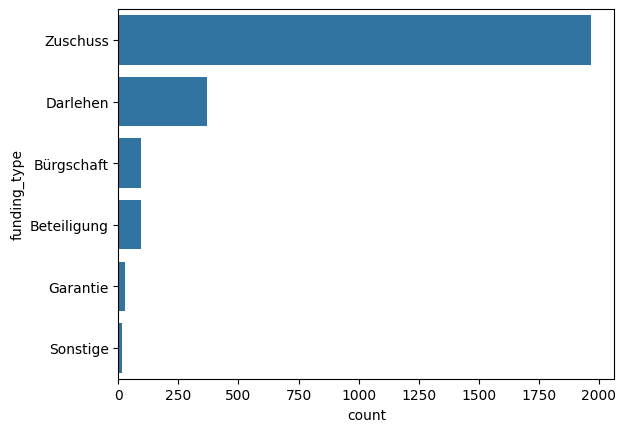

In [54]:
count_plot(df, "funding_type")

## Metadata

### Tracking added and deleted programs

In [74]:
if len(df.filter(df["last_updated"].is_null())) != len(df):
    df = df.with_columns(
        pl.col("on_website_from").alias("creation_date")
    )

    df = df.with_columns(
        [pl.col("creation_date").dt.truncate("1w").alias("week_start_date")]
    )

    earliest_date = df.select(pl.col("creation_date").min()).item()
    df_filtered = df.filter(pl.col("creation_date") != earliest_date)

    weekly_added = (
        df_filtered.filter(~pl.col("deleted"))
        .group_by("week_start_date")
        .len()
        .rename({"len": "added_count"})
        .sort("week_start_date")
    )

    weekly_deleted = (
        df_filtered.filter(pl.col("deleted"))
        .group_by("week_start_date")
        .len()
        .rename({"len": "deleted_count"})
        .sort("week_start_date")
    )

    weekly_counts = weekly_added.join(
        weekly_deleted, on="week_start_date", how="full"
    ).fill_null(0)

    plt.figure(figsize=(12, 6))

    sns.lineplot(
        data=weekly_counts,
        x="week_start_date",
        y="added_count",
        marker="o",
        label="Added Programs",
    )
    sns.lineplot(
        data=weekly_counts,
        x="week_start_date",
        y="deleted_count",
        marker="o",
        label="Deleted Programs",
        color="red",
    )

    plt.title("Programs Added and Deleted Per Week")
    plt.xlabel("Date")
    plt.ylabel("Number of Programs")
    plt.legend()

    plt.gcf().autofmt_xdate()

    plt.tight_layout()
    plt.show()
else:
    print("No update history available yet")


No update history available yet


### Type of programs being deleted and updated

In [83]:
if len(df.filter(df["last_updated"].is_null())) != len(df):
    current_date = datetime.now()
    one_month_ago = current_date - timedelta(days=30)
    recent_del = df.filter(pl.col("creation_date") > one_month_ago).filter(
        pl.col("deleted")
    )

    perc_comp(
        recent_del,
        df,
        "funding_area",
        f"Comparison of percentage for funding areas deleted in last month ({len(recent_del)}) vs. percentage of total previous data",
    )
else:
    print("No update history available yet")

No update history available yet


In [82]:
if len(df.filter(df["last_updated"].is_null())) != len(df):
    recent_add = df.filter(pl.col("creation_date") > one_month_ago).filter(
        ~pl.col("deleted") 
    )

    perc_comp(
        recent_add,
        df,
        "funding_area",
        f"Comparison of percentage of funding areas added in the last month ({len(recent_add)}) vs. percentage of total previous data",
    )
else:
    print("No update history available yet")

No update history available yet
